## Testing LSTM model with GloVe Embeddings

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, SimpleRNN, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
!ls "/content/drive/My Drive/News"

Fake.csv  glove.twitter.27B.100d.txt  True.csv


In [6]:
fake_df = pd.read_csv('/content/drive/My Drive/News/Fake.csv')
fake_df.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
real_df = pd.read_csv('/content/drive/My Drive/News/True.csv')
real_df.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_df.shape


(23481, 4)

In [9]:
real_df.shape

(21417, 4)

### Preprocessing Text

In [10]:
real_df["class"] = 1
fake_df["class"] = 0

In [11]:
real_df["text"] = real_df["title"] + " " + real_df["text"]
fake_df["text"] = fake_df["title"] + " " + fake_df["text"]

In [12]:
real_df = real_df.drop(["subject", "date","title"], axis=1)
fake_df = fake_df.drop(["subject", "date", "title"], axis=1)

In [13]:
real_df.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [14]:
fake_df.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [15]:
df = real_df.append(fake_df, ignore_index=True)
del real_df, fake_df

In [16]:
y = df["class"].values
#Converting X to format acceptable by GloVe, removing and punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

In [17]:
X[:1]

[['budget',
  'fight',
  'looms',
  'republicans',
  'flip',
  'fiscal',
  'script',
  'washington',
  'reuters',
  'head',
  'conservative',
  'republican',
  'faction',
  'congress',
  'voted',
  'month',
  'huge',
  'expansion',
  'national',
  'debt',
  'pay',
  'tax',
  'cuts',
  'called',
  'fiscal',
  'conservative',
  'sunday',
  'urged',
  'budget',
  'restraint',
  '2018',
  'keeping',
  'sharp',
  'pivot',
  'way',
  'among',
  'republicans',
  'representative',
  'mark',
  'meadows',
  'speaking',
  'cbs',
  'face',
  'nation',
  'drew',
  'hard',
  'line',
  'federal',
  'spending',
  'lawmakers',
  'bracing',
  'battle',
  'january',
  'return',
  'holidays',
  'wednesday',
  'lawmakers',
  'begin',
  'trying',
  'pass',
  'federal',
  'budget',
  'fight',
  'likely',
  'linked',
  'issues',
  'immigration',
  'policy',
  'even',
  'november',
  'congressional',
  'election',
  'campaigns',
  'approach',
  'republicans',
  'seek',
  'keep',
  'control',
  'congress',
  'p

In [18]:
y[:5]

array([1, 1, 1, 1, 1])

In [19]:
y[-5:]

array([0, 0, 0, 0, 0])

In [20]:
# Set max_feat and maxlen
max_features = 10000
maxlen = 700

In [21]:
# Instantiate and fit tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)


In [22]:
# Preview
X[0]

[392,
 395,
 56,
 5522,
 1287,
 4849,
 33,
 13,
 315,
 205,
 17,
 6213,
 102,
 694,
 161,
 1029,
 2862,
 50,
 825,
 350,
 95,
 1097,
 74,
 1287,
 205,
 242,
 1038,
 392,
 7567,
 1056,
 1653,
 3240,
 7798,
 77,
 231,
 56,
 711,
 786,
 7540,
 513,
 1786,
 341,
 221,
 1678,
 411,
 450,
 89,
 597,
 321,
 1243,
 316,
 657,
 7867,
 113,
 321,
 1333,
 274,
 769,
 89,
 392,
 395,
 223,
 1562,
 338,
 211,
 117,
 36,
 388,
 485,
 26,
 1933,
 1420,
 56,
 1013,
 297,
 245,
 102,
 3,
 14,
 1,
 56,
 96,
 284,
 392,
 878,
 87,
 597,
 109,
 10,
 96,
 3476,
 619,
 262,
 597,
 909,
 73,
 879,
 4053,
 995,
 1355,
 86,
 214,
 1291,
 1113,
 1,
 64,
 203,
 1265,
 48,
 62,
 878,
 619,
 262,
 597,
 60,
 7540,
 489,
 639,
 3393,
 12,
 680,
 1998,
 2,
 234,
 109,
 97,
 369,
 139,
 303,
 15,
 350,
 1207,
 217,
 445,
 60,
 1287,
 205,
 99,
 1816,
 289,
 5,
 171,
 2,
 7540,
 231,
 56,
 694,
 503,
 520,
 29,
 825,
 7117,
 95,
 2199,
 360,
 89,
 392,
 2189,
 1925,
 2198,
 217,
 40,
 318,
 2198,
 50,
 825,
 2231,
 10

In [23]:
#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

### Vectorization

In [24]:
# Get pre-trained word vectors
twitter_file = '/content/drive/My Drive/News/glove.twitter.27B.100d.txt' 

In [25]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

# Create dictionary
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(twitter_file))

In [26]:
# Get embeddings
embeddings = np.stack(embeddings_index.values())

# Get mean
embeddings_mean = embeddings.mean()

# Get standard deviation
embeddings_std = embeddings.std()

word_index = tokenizer.word_index

# Get number of words
numwords = min(max_features, len(word_index))

In [27]:
# Size of embeddings
embeddings_size = embeddings.shape[1]

# Create embeddings matrix
embedding_matrix = np.random.normal(embeddings_mean, embeddings_std, (numwords, embeddings_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [28]:
# Get shape
embedding_matrix.shape

(10000, 100)

### LSTM

In [29]:
# Set parameters
batch_size = 256
epochs = 3
embeddingsize = 100

In [30]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embeddingsize, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________


In [32]:
# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
model.fit(X_train, y_train, epochs = 1)

1053/1053 [==============================] - 1067s 1s/step - loss: 0.1844 - acc: 0.9299


In [34]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

351/351 [==============================] - 153s 434ms/step


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5852
           1       0.96      0.94      0.95      5373

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[5658,  194],
       [ 324, 5049]])

Text(95.72222222222221, 0.5, 'Truth')

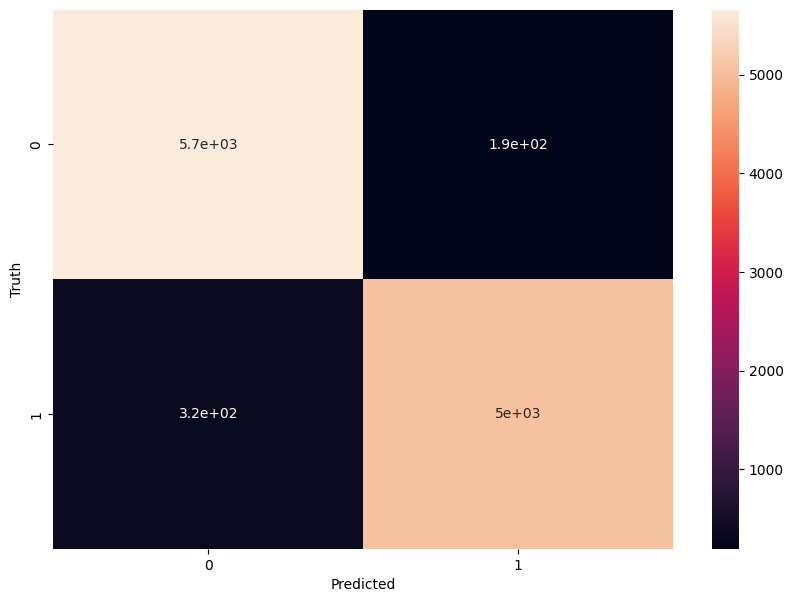

In [37]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
accuracy_score(y_test, y_pred)

0.9538530066815145

In [39]:
recall_score(y_test, y_pred)

0.9396984924623115

In [40]:
precision_score(y_test, y_pred)

0.9629982834255197

In [41]:
f1_score(y_test, y_pred)

0.9512057272042199